In [1]:
# from preproc_tools import get_fr_by_sample, to_python_hdf5
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
import json
from pathlib import Path
import h5py
from sklearn.svm import SVC
from scipy.spatial.distance import pdist
import pickle
import pandas as pd
from datetime import datetime
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.results import Results
from ephysvibe.trials import  select_trials
from ephysvibe.trials.spikes import firing_rate
from typing import Dict, List
import tools_decoding
seed=1997

### Prepeare data for decoding

In [2]:
# import gc


# # importing the module
# import tracemalloc

# # starting the monitoring
# tracemalloc.start()
# print(tracemalloc.get_traced_memory())
# # function call
# # preprocessing 
# popu = PopulationData.from_python_hdf5("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/v4/2024_08_28_12_23_36/population.h5")

# # displaying the memory
# print(tracemalloc.get_traced_memory())

# del popu

# print(tracemalloc.get_traced_memory())
# # stopping the library
# gc.collect()
# print(tracemalloc.get_traced_memory())
# tracemalloc.stop()

In [5]:
args={
    "preprocessing": {
        "to_decode": "orient",
        "min_ntr": 25,
        "start_sample": -200,
        "end_sample": 850,
        "start_test": -400,
        "end_test": 500,
        "step": 10,
        "time_before_son": "time_before_son_contra",
        "time_before_t1on": "time_before_t1on_contra",
        "sp_son": "sp_son_contra",
        "sp_t1on": "sp_t1on_contra",
        "mask_son": "mask_son_contra",
        "no_match": True,
    },
    # decoder
    "decoder": {"niterations": 200, "ntr_train": 30, "ntr_test": 10, "svc_c": 0.8},
    # workspace
    "workspace": {"output": "", "path": ""},
}

In [3]:
popu = PopulationData.from_python_hdf5("//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/contra_ipsi/lip/2024_08_30_10_04_40/population.h5")

In [6]:
#popu = PopulationData.from_python_hdf5("/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/contra_ipsi/v4/2024_08_30_10_24_04/population.h5")
list_data = popu.execute_function(
    tools_decoding.preproc_for_decoding,
    **args['preprocessing'],
    ret_df=False,
)
list_data = [idata for idata in list_data if idata is not None]

100%|██████████| 530/530 [00:12<00:00, 43.76it/s] 


In [8]:
len(list_data)

361

### Decode

In [6]:
model = SVC(
    kernel="linear",
    C=args['decoder']["svc_c"],
    decision_function_shape="ovr",
    gamma="auto",
    degree=1,
)
rng = np.random.default_rng(seed)
niterations = args['decoder']["niterations"]
ntr_train = args['decoder']["ntr_train"]
ntr_test = args['decoder']["ntr_test"]
to_decode = args['preprocessing']["to_decode"]

# Decode
trial_duration = int(
    (
        (args['preprocessing']["end_sample"] - args['preprocessing']["start_sample"])
        + (args['preprocessing']["end_test"] - args['preprocessing']["start_test"])
    )
    / args['preprocessing']["step"]
)

In [7]:
seeds = rng.choice(np.arange(0, 3000), size=niterations, replace=False)
all_perf = Parallel(n_jobs=5)(
    delayed(tools_decoding.run_decoder)(
        model, list_data, trial_duration, ntr_train, ntr_test, to_decode, seeds[it]
    )
    for it in tqdm(range(niterations))
)

100%|██████████| 200/200 [15:57<00:00,  4.79s/it]


<Axes: >

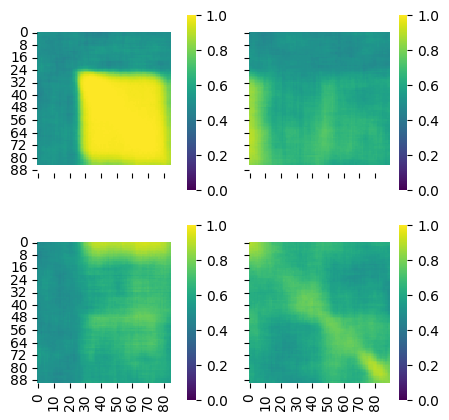

In [9]:
f,ax=plt.subplots(2,2,figsize=(5,5),sharex=True,sharey=True)
A=(np.mean(all_perf,axis=0)/20)[0:85,0:85]
B=(np.mean(all_perf,axis=0)/20)[105:,0:85]
C=(np.mean(all_perf,axis=0)/20)[0:85,105:]
D=(np.mean(all_perf,axis=0)/20)[105:,105:]
sns.heatmap(A,ax=ax[0,0],cmap='viridis',square=True,vmin=0,vmax=1)
sns.heatmap(B,ax=ax[1,0],cmap='viridis',square=True,vmin=0,vmax=1)
sns.heatmap(C,ax=ax[0,1],cmap='viridis',square=True,vmin=0,vmax=1)
sns.heatmap(D,ax=ax[1,1],cmap='viridis',square=True,vmin=0,vmax=1)

In [10]:
test=np.concatenate([np.concatenate([A,C],axis=1),np.concatenate([B,D],axis=1)],axis=0)

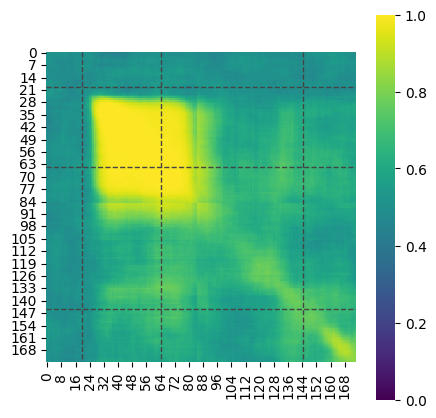

In [11]:
f,ax=plt.subplots(figsize=(5,5))
chance = 0.5
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
sns.heatmap(test,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)

#ax.axes.invert_yaxis()
ax.vlines([20,65],0,190,'#444444','--',linewidth=1)
ax.hlines([20,65],0,190,'#444444','--',linewidth=1)
# ax.vlines([105],0,190,'white',linewidth=3)
# ax.hlines([105],0,190,'white',linewidth=3)
ax.vlines([145],0,190,'#444444','--',linewidth=1)
ax.hlines([145],0,190,'#444444','--',linewidth=1)
# ax.set_yticks(ticks)
# ax.set_xticks(ticks)
# ax.set_yticklabels(label_ticks)
# ax.set_xticklabels(label_ticks)

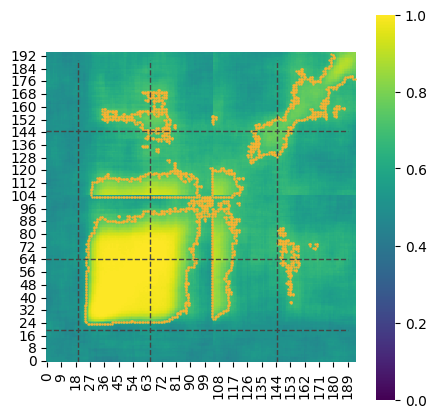

In [15]:
f,ax=plt.subplots(figsize=(5,5))
chance = 0.5
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
sns.heatmap(np.mean(all_perf,axis=0)/20,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)
xx,yy=define_contour_latencies(np.sum(np.array(all_perf)>10,axis=0), thresh=190)

ax.scatter(xx,yy,s=0.5,color = '#F9B233')
ax.axes.invert_yaxis()
ax.vlines([20,65],0,190,'#444444','--',linewidth=1)
ax.hlines([20,65],0,190,'#444444','--',linewidth=1)
# ax.vlines([105],0,190,'white',linewidth=3)
# ax.hlines([105],0,190,'white',linewidth=3)
ax.vlines([145],0,190,'#444444','--',linewidth=1)
ax.hlines([145],0,190,'#444444','--',linewidth=1)
# ax.set_yticks(ticks)
# ax.set_xticks(ticks)
# ax.set_yticklabels(label_ticks)
# ax.set_xticklabels(label_ticks)

In [5]:
list_todecode = np.array([['neutral','sampleid','color'],['orient','sampleid','color']])
list_areas = np.array([['lip','pfc','v4'],['lip','pfc','v4']])
list_rfpos = np.array([['in_rf','in_rf','in_rf'],['out_rf','out_rf','out_rf']])

In [5]:
def define_contour_latencies(data, thresh):
        
    X,Y = np.where(data>=thresh)
    A=np.zeros(data.shape)
    A[X,Y]=1
    Ya,Xa    =   np.where(np.abs(np.diff(A, axis=0))!=0)
    Yb,Xb    =   np.where(np.abs(np.diff(A, axis=1))!=0)
    Yy  =   np.concatenate([Ya, Yb])
    Xx  =   np.concatenate([Xa, Xb])
    return Xx,Yy

In [30]:
save = False
im_format='svg'

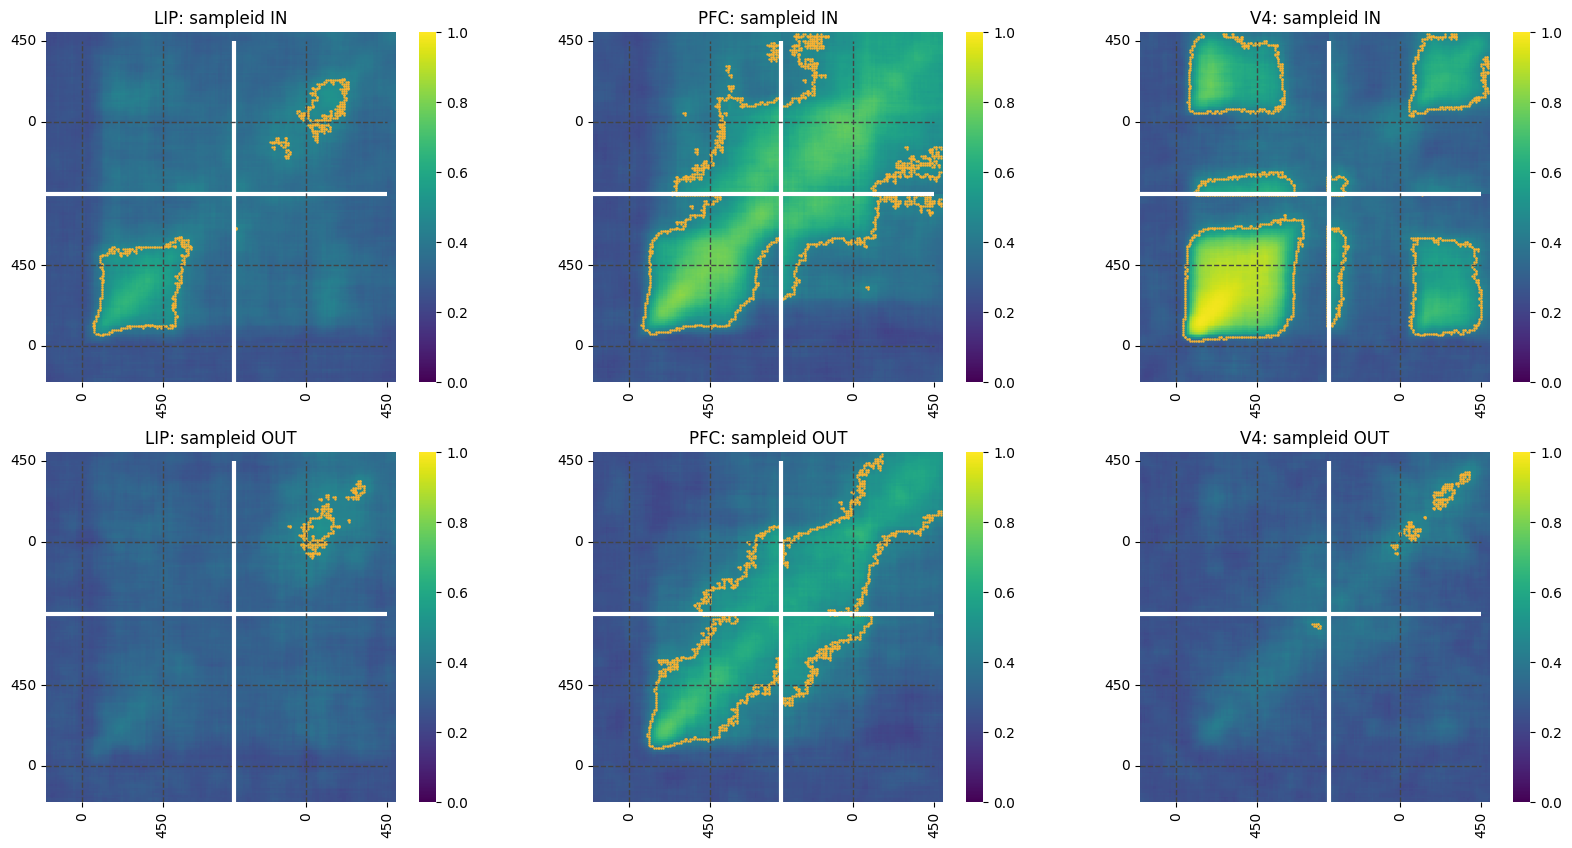

In [31]:
to_decode ='sampleid'
date = '2024_08_29_15_43_20'
chance = 0.25
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
f,ax=plt.subplots(2,3,figsize=(20,10))
for j in range(2):
    for i in range(3):
        #to_decode = list_todecode[j,i]
        area = list_areas[j,i]
        rfpos = list_rfpos[j,i]
        res = Results.from_python_hdf5(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/{date}/{rfpos}/{to_decode}/{area}/performance_decoder.h5')
        xx,yy=define_contour_latencies(np.sum(res.perf>chance,axis=0), thresh=990)
        sns.heatmap(np.mean(res.perf,axis=0),ax=ax[j,i],cmap='viridis',square=True,vmin=0,vmax=1)
        ax[j,i].scatter(xx,yy,s=0.5,color = '#F9B233')
        ax[j,i].axes.invert_yaxis()
        ax[j,i].vlines([20,65],0,190,'#444444','--',linewidth=1)
        ax[j,i].hlines([20,65],0,190,'#444444','--',linewidth=1)
        ax[j,i].vlines([105],0,190,'white',linewidth=3)
        ax[j,i].hlines([105],0,190,'white',linewidth=3)
        ax[j,i].vlines([145],0,190,'#444444','--',linewidth=1)
        ax[j,i].hlines([145],0,190,'#444444','--',linewidth=1)
        ax[j,i].set_yticks(ticks)
        ax[j,i].set_xticks(ticks)
        ax[j,i].set_yticklabels(label_ticks)
        ax[j,i].set_xticklabels(label_ticks)
        ax[j,i].set_title(f'{area.upper()}: {to_decode} {rfpos.split("_")[0].upper()}')
if save:
    f.savefig(f'./{to_decode}.{im_format}',format=im_format,bbox_inches="tight")

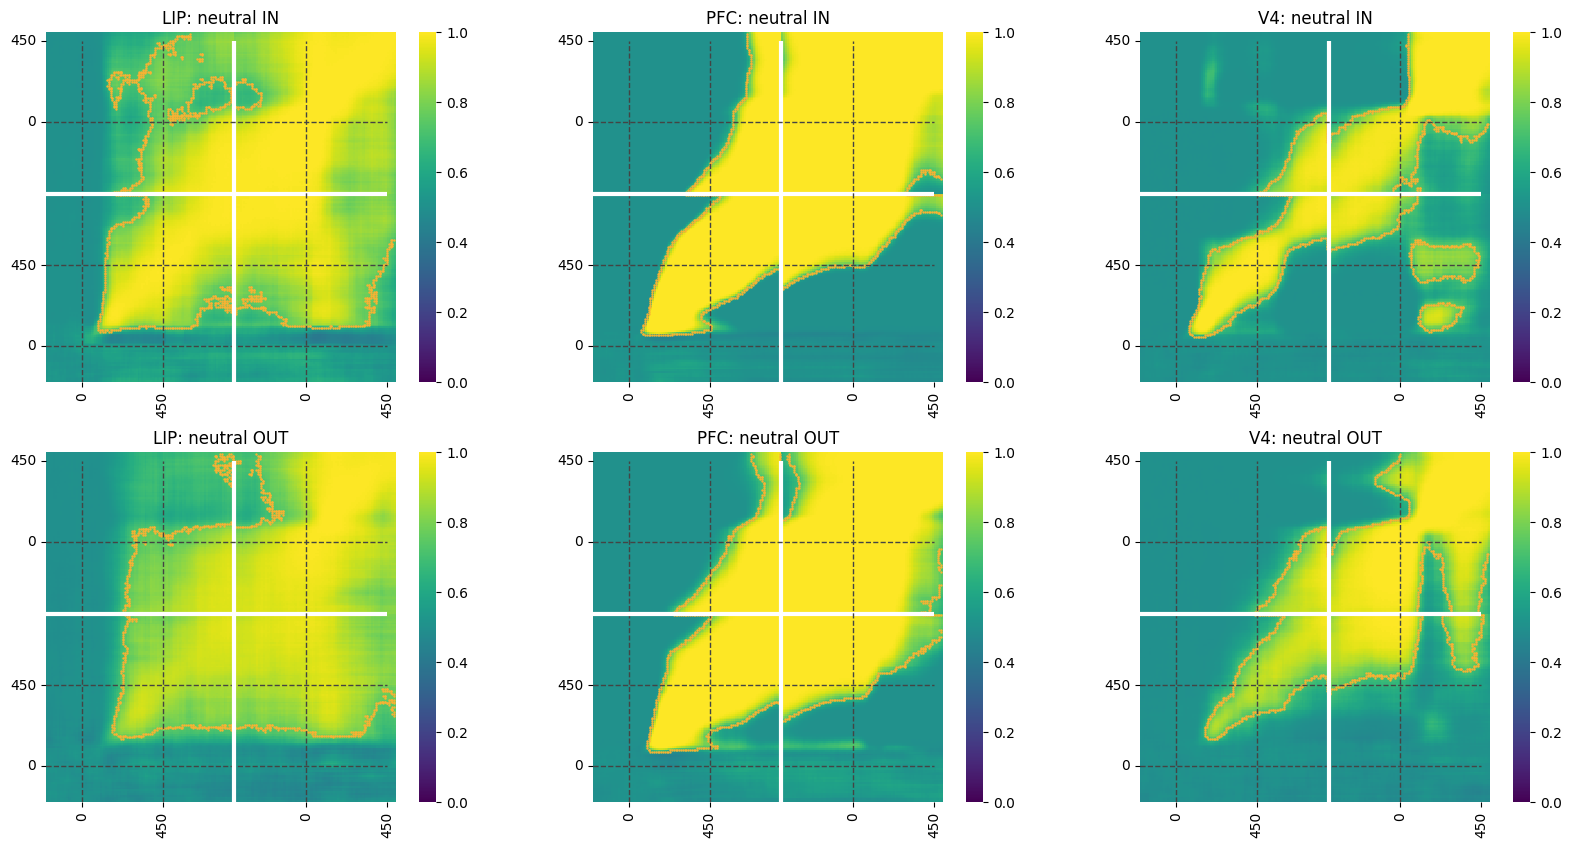

In [32]:
to_decode ='neutral'
date = '2024_08_29_15_43_20'
chance = 0.5
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
f,ax=plt.subplots(2,3,figsize=(20,10))
for j in range(2):
    for i in range(3):
        #to_decode = list_todecode[j,i]
        area = list_areas[j,i]
        rfpos = list_rfpos[j,i]
        res = Results.from_python_hdf5(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/{date}/{rfpos}/{to_decode}/{area}/performance_decoder.h5')
        xx,yy=define_contour_latencies(np.sum(res.perf>chance,axis=0), thresh=990)
        sns.heatmap(np.mean(res.perf,axis=0),ax=ax[j,i],cmap='viridis',square=True,vmin=0,vmax=1)
        ax[j,i].scatter(xx,yy,s=0.5,color = '#F9B233')
        ax[j,i].axes.invert_yaxis()
        ax[j,i].vlines([20,65],0,190,'#444444','--',linewidth=1)
        ax[j,i].hlines([20,65],0,190,'#444444','--',linewidth=1)
        ax[j,i].vlines([105],0,190,'white',linewidth=3)
        ax[j,i].hlines([105],0,190,'white',linewidth=3)
        ax[j,i].vlines([145],0,190,'#444444','--',linewidth=1)
        ax[j,i].hlines([145],0,190,'#444444','--',linewidth=1)
        ax[j,i].set_yticks(ticks)
        ax[j,i].set_xticks(ticks)
        ax[j,i].set_yticklabels(label_ticks)
        ax[j,i].set_xticklabels(label_ticks)
        ax[j,i].set_title(f'{area.upper()}: {to_decode} {rfpos.split("_")[0].upper()}')
if save:
    f.savefig(f'./{to_decode}.{im_format}',format=im_format,bbox_inches="tight")

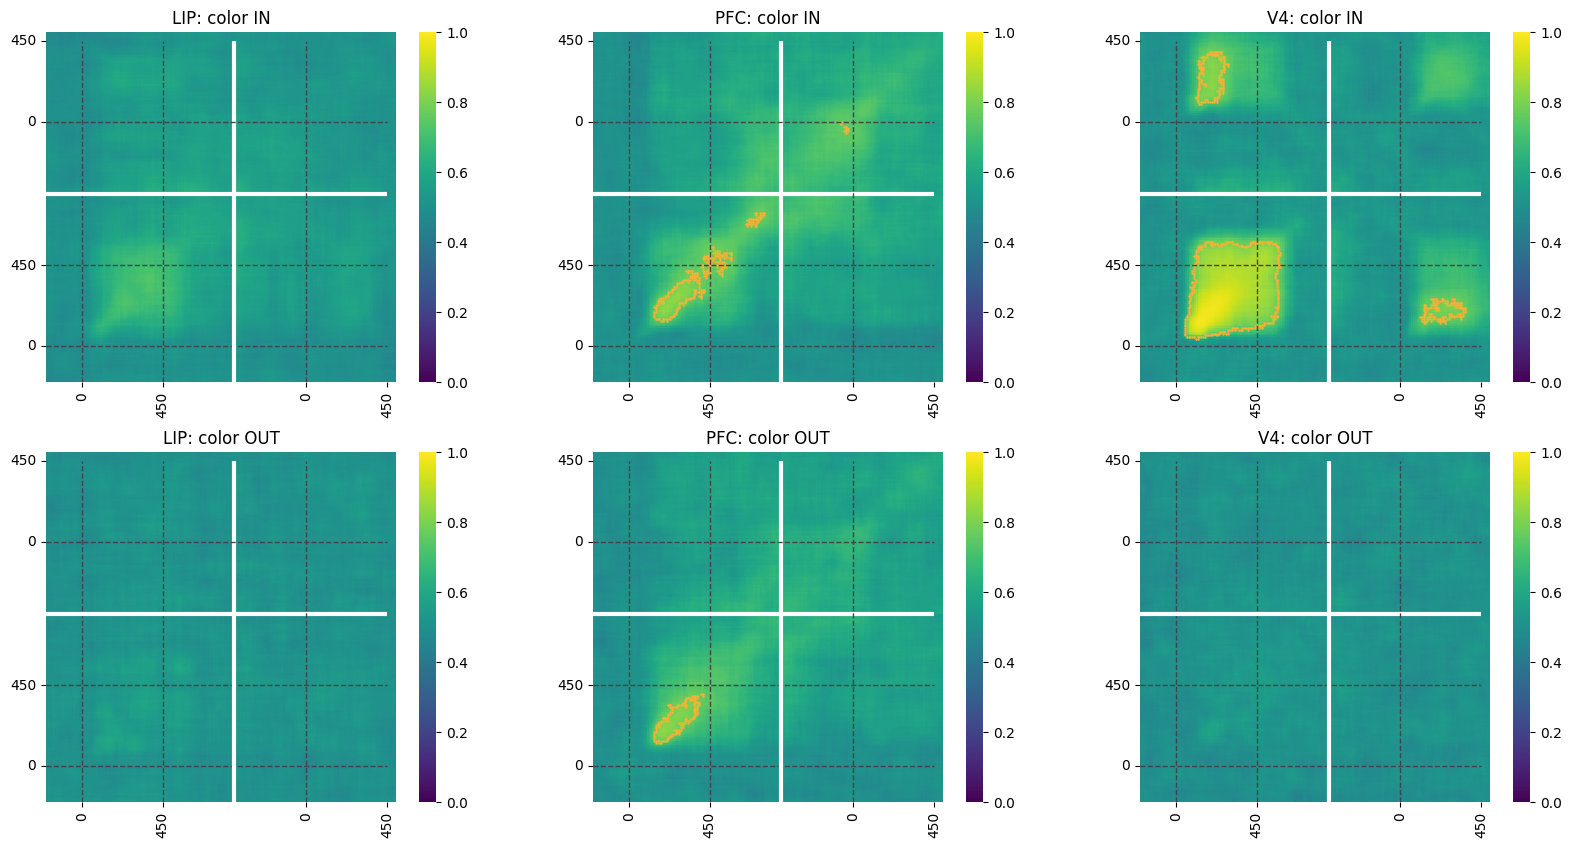

In [33]:
to_decode ='color'
date = '2024_08_29_15_43_20'
chance = 0.5
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
f,ax=plt.subplots(2,3,figsize=(20,10))
for j in range(2):
    for i in range(3):
        #to_decode = list_todecode[j,i]
        area = list_areas[j,i]
        rfpos = list_rfpos[j,i]
        res = Results.from_python_hdf5(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/{date}/{rfpos}/{to_decode}/{area}/performance_decoder.h5')
        xx,yy=define_contour_latencies(np.sum(res.perf>chance,axis=0), thresh=990)
        sns.heatmap(np.mean(res.perf,axis=0),ax=ax[j,i],cmap='viridis',square=True,vmin=0,vmax=1)
        ax[j,i].scatter(xx,yy,s=0.5,color = '#F9B233')
        ax[j,i].axes.invert_yaxis()
        ax[j,i].vlines([20,65],0,190,'#444444','--',linewidth=1)
        ax[j,i].hlines([20,65],0,190,'#444444','--',linewidth=1)
        ax[j,i].vlines([105],0,190,'white',linewidth=3)
        ax[j,i].hlines([105],0,190,'white',linewidth=3)
        ax[j,i].vlines([145],0,190,'#444444','--',linewidth=1)
        ax[j,i].hlines([145],0,190,'#444444','--',linewidth=1)
        ax[j,i].set_yticks(ticks)
        ax[j,i].set_xticks(ticks)
        ax[j,i].set_yticklabels(label_ticks)
        ax[j,i].set_xticklabels(label_ticks)
        ax[j,i].set_title(f'{area.upper()}: {to_decode} {rfpos.split("_")[0].upper()}')
if save:
    f.savefig(f'./{to_decode}.{im_format}',format=im_format,bbox_inches="tight")        

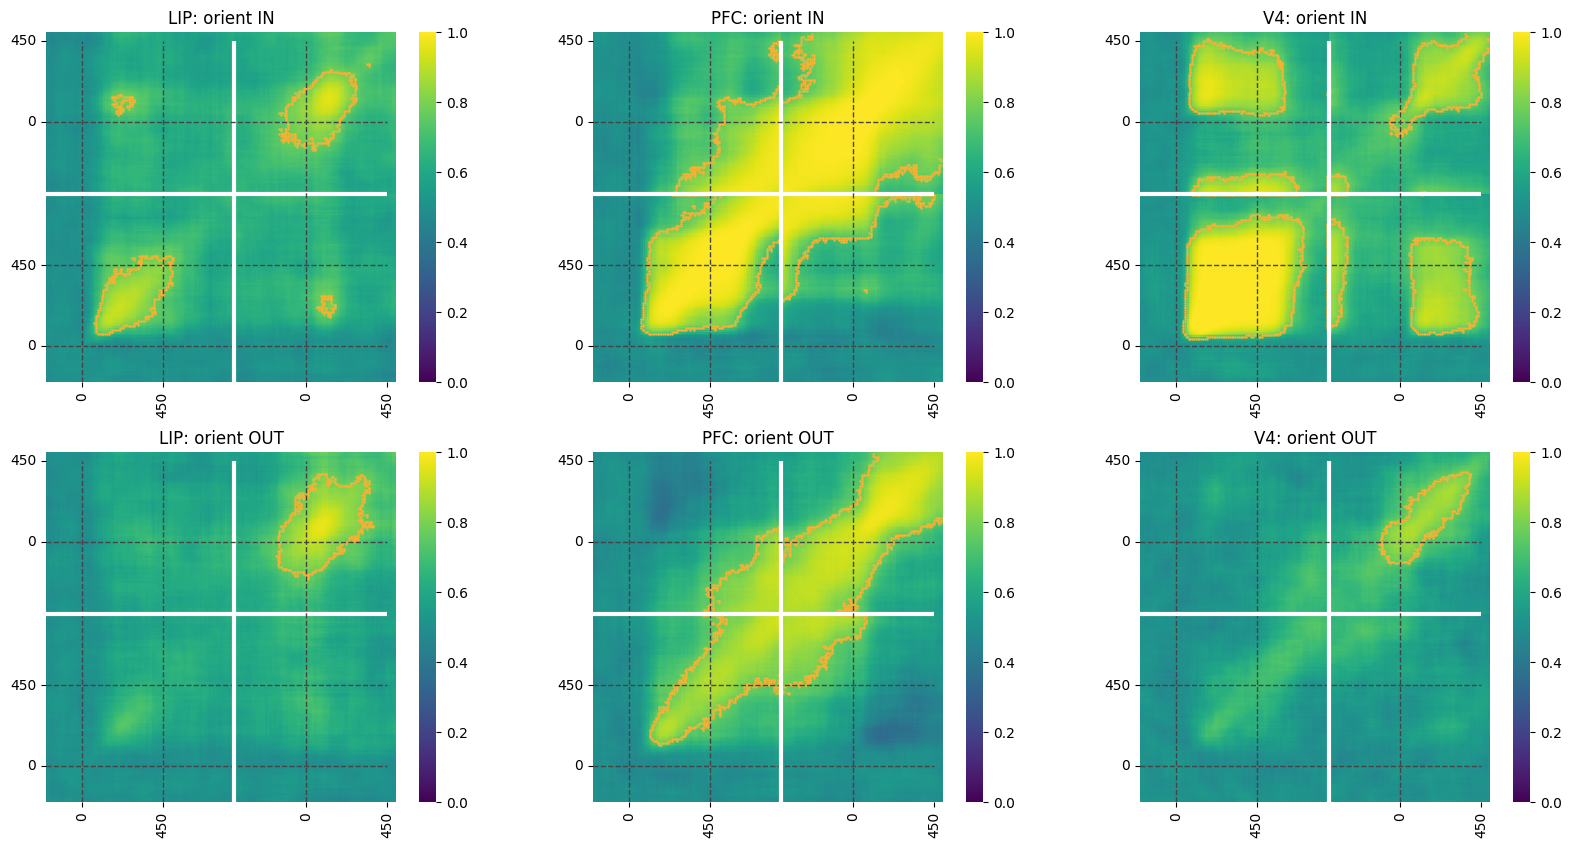

In [34]:
to_decode ='orient'
date = '2024_08_29_15_43_20'
chance = 0.5
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
f,ax=plt.subplots(2,3,figsize=(20,10))
for j in range(2):
    for i in range(3):
        #to_decode = list_todecode[j,i]
        area = list_areas[j,i]
        rfpos = list_rfpos[j,i]
        res = Results.from_python_hdf5(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/{date}/{rfpos}/{to_decode}/{area}/performance_decoder.h5')
        xx,yy=define_contour_latencies(np.sum(res.perf>chance,axis=0), thresh=990)
        sns.heatmap(np.mean(res.perf,axis=0),ax=ax[j,i],cmap='viridis',square=True,vmin=0,vmax=1)
        ax[j,i].scatter(xx,yy,s=0.5,color = '#F9B233')
        ax[j,i].axes.invert_yaxis()
        ax[j,i].vlines([20,65],0,190,'#444444','--',linewidth=1)
        ax[j,i].hlines([20,65],0,190,'#444444','--',linewidth=1)
        ax[j,i].vlines([105],0,190,'white',linewidth=3)
        ax[j,i].hlines([105],0,190,'white',linewidth=3)
        ax[j,i].vlines([145],0,190,'#444444','--',linewidth=1)
        ax[j,i].hlines([145],0,190,'#444444','--',linewidth=1)
        ax[j,i].set_yticks(ticks)
        ax[j,i].set_xticks(ticks)
        ax[j,i].set_yticklabels(label_ticks)
        ax[j,i].set_xticklabels(label_ticks)
        ax[j,i].set_title(f'{area.upper()}: {to_decode} {rfpos.split("_")[0].upper()}')
if save:
    f.savefig(f'./{to_decode}.{im_format}',format=im_format,bbox_inches="tight")

In [11]:
plt.close()

### plot diagonal

In [12]:
list_areas = np.array([['lip','pfc','v4'],['lip','pfc','v4']])
list_rfpos = np.array([['in_rf','in_rf','in_rf'],['out_rf','out_rf','out_rf']])

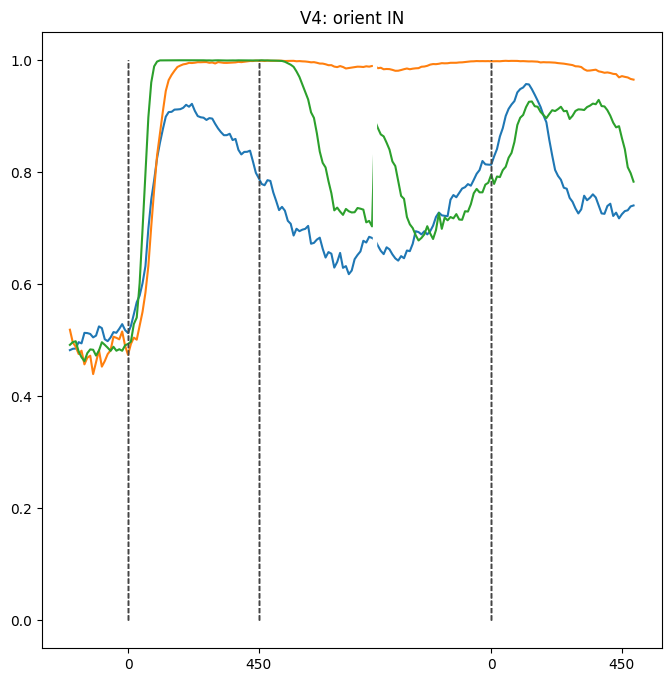

In [13]:
to_decode ='orient'
date = '2024_08_29_15_43_20'
chance = 0.5
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
f,ax=plt.subplots(figsize=(8,8))
for j in range(1):
    for i in range(3):
        #to_decode = list_todecode
        area = list_areas[j,i]
        rfpos = list_rfpos[j,i]
        res = Results.from_python_hdf5(f'/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/{date}/{rfpos}/{to_decode}/{area}/performance_decoder.h5')
        ax.plot(np.diag(np.mean(res.perf,axis=0)))
        ax.vlines([20,65],0,1,'#444444','--',linewidth=1)
        ax.vlines([105],0,1,'white',linewidth=3)
        ax.vlines([145],0,1,'#444444','--',linewidth=1)
        ax.set_xticks(ticks)
        ax.set_xticklabels(label_ticks)
        ax.set_title(f'{to_decode} ')
if save:
    f.savefig(f'./{to_decode}.{im_format}',format=im_format,bbox_inches="tight")

### Individual plots

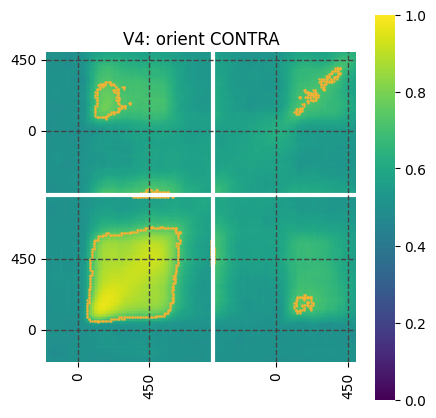

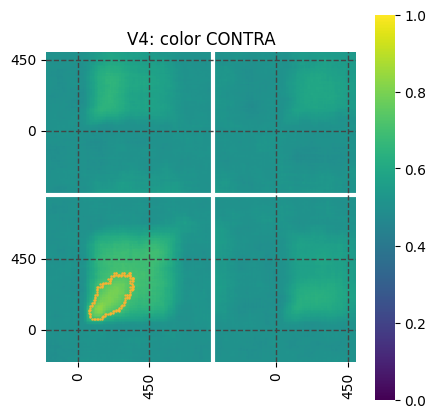

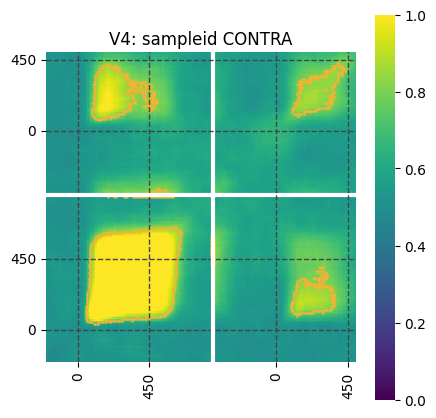

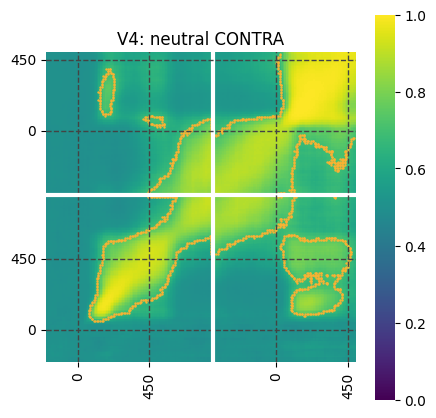

In [48]:
rfpos='contra_rf'
date = '2024_09_08_16_58_27'
for area in ['v4']:
    for to_decode in ['orient','color','sampleid','neutral']:   
        chance = 0.5
        if to_decode=='sampleid':chance=0.25

        res = Results.from_python_hdf5(f'//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/contra_361cells/{date}/{rfpos}/{to_decode}/{area}/performance_decoder.h5')

        f,ax=plt.subplots(figsize=(5,5))
        ticks= [20,65,145,190]
        label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
        xx,yy=define_contour_latencies(np.sum(res.perf>10,axis=0), thresh=950)
        sns.heatmap(np.mean(res.perf,axis=0)/20,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)
        ax.scatter(xx,yy,s=0.5,color = '#F9B233')
        ax.axes.invert_yaxis()
        ax.vlines([20,65],0,200,'#444444','--',linewidth=1)
        ax.hlines([20,65],0,200,'#444444','--',linewidth=1)
        ax.vlines([105],0,200,'white',linewidth=3)
        ax.hlines([105],0,200,'white',linewidth=3)
        ax.vlines([145,190],0,200,'#444444','--',linewidth=1)
        ax.hlines([145,190],0,200,'#444444','--',linewidth=1)
        ax.set_yticks(ticks)
        ax.set_xticks(ticks)
        ax.set_yticklabels(label_ticks)
        ax.set_xticklabels(label_ticks)
        ax.set_title(f'{area.upper()}: {to_decode} {rfpos.split("_")[0].upper()}')

### Plot one condition

In [41]:
area='v4'
to_decode ='sampleid'
rfpos='contra_rf'
chance = 0.5
date = '2024_09_08_12_49_18'
res = Results.from_python_hdf5(f'//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/decoding/contra_200cells/{date}/{rfpos}/{to_decode}/{area}/performance_decoder.h5')

Text(0.5, 1.0, 'V4: sampleid CONTRA')

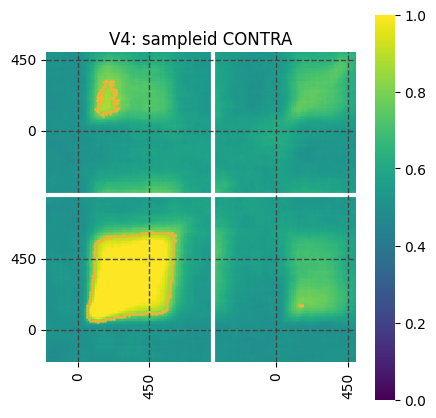

In [42]:
f,ax=plt.subplots(figsize=(5,5))
ticks= [20,65,145,190]
label_ticks = ((np.array([20,65,20,65])-20)*10).astype(str)
xx,yy=define_contour_latencies(np.sum(res.perf>10,axis=0), thresh=950)
sns.heatmap(np.mean(res.perf,axis=0)/20,ax=ax,cmap='viridis',square=True,vmin=0,vmax=1)
ax.scatter(xx,yy,s=0.5,color = '#F9B233')
ax.axes.invert_yaxis()
ax.vlines([20,65],0,200,'#444444','--',linewidth=1)
ax.hlines([20,65],0,200,'#444444','--',linewidth=1)
ax.vlines([105],0,200,'white',linewidth=3)
ax.hlines([105],0,200,'white',linewidth=3)
ax.vlines([145,190],0,200,'#444444','--',linewidth=1)
ax.hlines([145,190],0,200,'#444444','--',linewidth=1)
ax.set_yticks(ticks)
ax.set_xticks(ticks)
ax.set_yticklabels(label_ticks)
ax.set_xticklabels(label_ticks)
ax.set_title(f'{area.upper()}: {to_decode} {rfpos.split("_")[0].upper()}')